In [11]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input,Add,GlobalAveragePooling2D,Activation,AveragePooling2D,concatenate,Conv2DTranspose
from keras.models import Model

In [17]:
# loading LOLdataset for model to train upon (change the path to your folder)
low_img=glob("/Downloads/DeepLearning/LowLit_denoise/LOLdataset/our485/low/*.png")
high_img=glob("/Downloads/DeepLearning/LowLit_denoise/LOLdataset/our485/high/*.png")

In [18]:
low_img=np.sort(low_img)
high_img=np.sort(high_img)

In [19]:
# creating target for CBDNet to train upon #cleaning the noise in low light image
def dim(limg,himg):
  limg=cv.imread(limg)
  himg=cv.imread(himg)
  limg=cv.cvtColor(limg,cv.COLOR_BGR2RGB)
  im=np.copy(himg)

  limg=cv.resize(limg,(512,512))


  im=cv.cvtColor(im,cv.COLOR_BGR2RGB)
  hsv=cv.cvtColor(im,cv.COLOR_RGB2HSV)
  hsv[...,2]=hsv[...,2]*0.15

  im=cv.cvtColor(hsv,cv.COLOR_HSV2RGB)
  im=cv.resize(im,(512,512))

  return limg,im


In [20]:
z,q=dim(low_img[0],high_img[0])

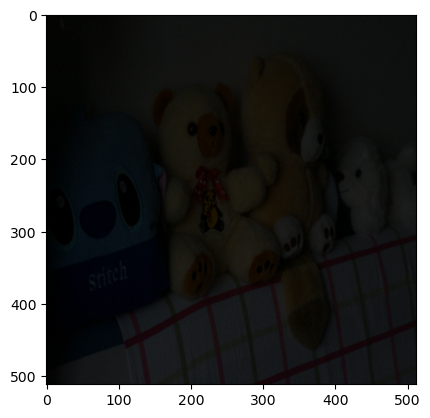

In [22]:
plt.imshow(q)

In [ ]:
x1=[]
y1=[]

for i,j in zip(low_img,high_img):
    l,h=dim(i,j)
    x1.append(l)
    y1.append(h)
    
x1=np.array(x1)
y1=np.array(y1)

array([[[1, 3, 0],
        [1, 3, 1],
        [1, 1, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [1, 1, 2]],

       [[1, 2, 1],
        [0, 2, 1],
        [0, 1, 0],
        ...,
        [1, 1, 0],
        [0, 0, 0],
        [0, 0, 1]],

       [[0, 1, 1],
        [1, 1, 1],
        [0, 1, 0],
        ...,
        [1, 1, 0],
        [0, 0, 1],
        [1, 0, 0]],

       ...,

       [[1, 3, 2],
        [2, 2, 2],
        [2, 2, 1],
        ...,
        [3, 3, 1],
        [1, 4, 1],
        [1, 3, 0]],

       [[0, 2, 2],
        [3, 2, 1],
        [2, 2, 0],
        ...,
        [3, 3, 2],
        [1, 3, 1],
        [1, 3, 1]],

       [[0, 3, 0],
        [3, 3, 1],
        [2, 2, 1],
        ...,
        [1, 2, 3],
        [0, 2, 1],
        [2, 3, 3]]], dtype=uint8)
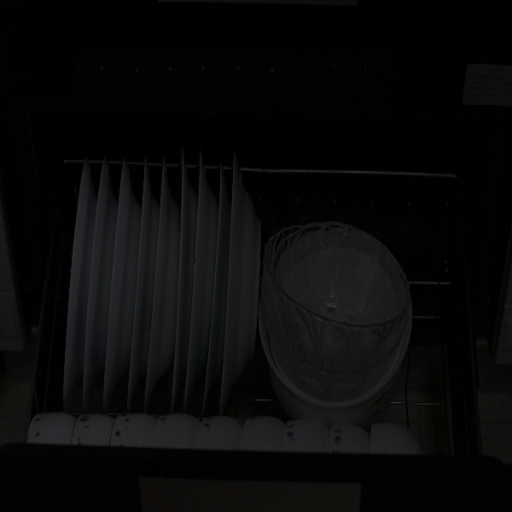

In [ ]:
x1[1]

In [30]:
# CBDNet model for denoising the low light image
tf.keras.backend.clear_session()
input = Input(shape=(512, 512, 3))

#Noise estimation subnetwork
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(3, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)

#Non Blind denoising subnetwork
x = concatenate([x,input])
conv1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
conv2 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv1)

pool1 = AveragePooling2D(pool_size=(2,2),padding='same')(conv2)
conv3 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool1)
conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv3)
conv5 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv4)

pool2 = AveragePooling2D(pool_size=(2,2),padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool2)
conv7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv6)
conv8 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv7)
conv9 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv8)
conv10 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv9)
conv11 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv10)

upsample1 = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv11)
add1 = Add()([upsample1,conv5])
conv12 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv13 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv12)
conv14 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv13)

upsample2 = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv14)
add1 = Add()([upsample2,conv2])
conv15 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv16 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv15)

out = Conv2D(3, (1,1), kernel_initializer='he_normal',padding="same")(conv16)
out = Add()([out,input])

CBDNet = Model(input,out)
CBDNet.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())


In [32]:
# Model Training
def GenerateInputs(X,y):
    for i in range(len(x1)):
        X_input = tf.image.convert_image_dtype((X[i].reshape(1,512,512,3)), tf.float32)
        y_input = tf.image.convert_image_dtype((y[i].reshape(1,512,512,3)), tf.float32)
        yield (X_input,y_input)
CBDNet.fit(GenerateInputs(x1,y1),epochs=30,verbose=1,steps_per_epoch=15,shuffle=True,batch_size=32)

Epoch 1/30
15/15 [==============================] - 3s 197ms/step - loss: 9.7010e-04
Epoch 2/30
15/15 [==============================] - 3s 200ms/step - loss: 3.9565e-04
Epoch 3/30
15/15 [==============================] - 3s 185ms/step - loss: 4.1717e-04
Epoch 4/30
15/15 [==============================] - 3s 183ms/step - loss: 5.8345e-04
Epoch 5/30
15/15 [==============================] - 3s 182ms/step - loss: 4.2283e-04
Epoch 6/30
15/15 [==============================] - 3s 187ms/step - loss: 6.4135e-04
Epoch 7/30
15/15 [==============================] - 3s 191ms/step - loss: 7.8915e-04
Epoch 8/30
15/15 [==============================] - 3s 184ms/step - loss: 8.7708e-04
Epoch 9/30
15/15 [==============================] - 3s 183ms/step - loss: 0.0013
Epoch 10/30
15/15 [==============================] - 3s 184ms/step - loss: 0.0154
Epoch 11/30
15/15 [==============================] - 3s 185ms/step - loss: 0.0051
Epoch 12/30
15/15 [==============================] - 3s 186ms/step - loss: 

In [ ]:
CBDNet.save('CBDNet_lowLit_refined.h5')